# **Notebook Purpose**

*The purpose of this notebook is to create a predictive model for attacks as part of a Network Intrusion Detection System (NIDS). The prediction is performed using a multi-layer classification approach.*

# **Import Library**

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn

from sklearn import preprocessing
from scipy.interpolate import PchipInterpolator
from imblearn.combine import SMOTEENN
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import itertools

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


from feature_engine.selection import (
    RecursiveFeatureElimination,
    RecursiveFeatureAddition
)

# **Load Dataset**

In [78]:
# Path to training dataset
train_PATH = 'D:\DAC-2023\Dataset\DataTrain_Preliminary.csv'
pred_PATH = 'D:\DAC-2023\Dataset\Data_Prediction.csv'

In [79]:
# Load dataset
df = pd.read_csv(train_PATH, delimiter=';')
df_pred = pd.read_csv(pred_PATH, delimiter=';')
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack
0,0,tcp,private,SH,0,0,0,0,0,0,...,1,0.01,0.94,0.95,0,0.95,1,0,0,nmap
1,0,tcp,private,S0,0,0,0,0,0,0,...,5,0.02,0.08,0.00,0,1.00,1,0,0,neptune
2,0,tcp,http,SF,285,3623,0,0,0,0,...,228,1.00,0.00,0.01,*,0.00,0,0,0,normal
3,0,tcp,http,SF,232,584,0,0,0,0,...,255,1.00,0.00,0.17,*,0.00,0,0,0,normal
4,1,tcp,smtp,SF,1080,327,0,0,0,0,...,154,0.58,0.02,0.00,*,0.00,0,0,0,normal


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112446 entries, 0 to 112445
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     112446 non-null  object 
 1   protocol_type                111778 non-null  object 
 2   service                      111426 non-null  object 
 3   flag                         111593 non-null  object 
 4   src_bytes                    112446 non-null  object 
 5   dst_bytes                    112446 non-null  object 
 6   land                         112446 non-null  object 
 7   wrong_fragment               112446 non-null  object 
 8   urgent                       112446 non-null  object 
 9   hot                          112446 non-null  object 
 10  num_failed_logins            112446 non-null  object 
 11  logged_in                    112446 non-null  object 
 12  num_compromised              112446 non-null  object 
 13 

Here we could see that the data type of every column is 'object' so we need to change the data type based on the value the column has.

In [81]:
print('Label distribution Training set:')
print(df['type_of_attack'].value_counts())

Label distribution Training set:
type_of_attack
normal                      60538
neptune                     37142
ipsweep                      3254
satan                        3248
portsweep                    2687
smurf                        2394
Denial of Service Attack     1861
nmap                         1322
Name: count, dtype: int64


We will use multi-layer classification to predict attacks.

1. If the network activity is classified as an anomaly:
   - If it's a Denial-of-Service (DoS) attack:
     - Perform multiclass classification to determine if it's a DoS, Neptune, or Smurf attack.
   - If it's a probe attack:
     - Perform multiclass classification to determine if it's Nmap, Portscan, Satan, or Ipsweep.
  
2. If the network activity is not classified as an anomaly, it is considered normal.

In [82]:
# Membuat kolom 'target' dengan nilai awal 'anomaly'
df['target'] = 'anomaly'

# Mengganti nilai kolom 'target' berdasarkan nilai kolom 'type_of_attack'
df.loc[df['type_of_attack'] == 'normal', 'target'] = 'normal'

# Sisipkan kolom 'target' tepat sebelum kolom terakhir
df.insert(df.columns.get_loc('type_of_attack'), 'target', df.pop('target'))

In [83]:
# Fungsi untuk menentukan nilai di kolom "attack"
def determine_attack_type(row):
    if row['type_of_attack'] == 'normal':
        return 'normal'
    elif row['type_of_attack'] in ['nmap', 'portsweep', 'satan', 'ipsweep']:
        return 'probe'
    elif row['type_of_attack'] in ['neptune', 'smurf', 'Denial of Service Attack']:
        return 'dos'
    else:
        return 'unknown'  # Jika jenis serangan tidak dikenali

# Buat kolom baru 'attack'
df['attack'] = df.apply(determine_attack_type, axis=1)

# Sisipkan kolom 'attack' tepat sebelum kolom terakhir
df.insert(len(df.columns) - 2, 'attack', df.pop('attack'))

In [84]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,attack,type_of_attack
0,0,tcp,private,SH,0,0,0,0,0,0,...,0.94,0.95,0,0.95,1,0,0,anomaly,probe,nmap
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.08,0.00,0,1.00,1,0,0,anomaly,dos,neptune
2,0,tcp,http,SF,285,3623,0,0,0,0,...,0.00,0.01,*,0.00,0,0,0,normal,normal,normal
3,0,tcp,http,SF,232,584,0,0,0,0,...,0.00,0.17,*,0.00,0,0,0,normal,normal,normal
4,1,tcp,smtp,SF,1080,327,0,0,0,0,...,0.02,0.00,*,0.00,0,0,0,normal,normal,normal


In [85]:
df.shape

(112446, 44)

# **Data Preprocessing**

## 1. Investigate Unique Value

In [86]:
# Initialize a dictionary to store missing value representations
missing_value_representations = ['', ' ', '-', 'NA', 'N/A', '999', '-999', None, 
                                 np.nan, '*', '9999', '-9999', '99999', '-99999',
                                 99999]

# Initialize a set to store unique types of missing values
unique_missing_value_types = set()

# Iterate through columns and check for missing value representations
for column in df.columns:
    for value in df[column]:
        if value in missing_value_representations:
            unique_missing_value_types.add(value)

# Boolean indexing to filter rows with unique missing value types
filtered_df = df[df.apply(lambda row: any(val in unique_missing_value_types for val in row), axis=1)]

# Display the filtered DataFrame
print("Unique types of missing values found in the DataFrame:")
print(unique_missing_value_types)
print("Rows containing unique missing value types:")
filtered_df

Unique types of missing values found in the DataFrame:
{nan, '*', '999', '99999', 99999.0}
Rows containing unique missing value types:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,attack,type_of_attack
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.08,0.00,0,1.00,1,0,0,anomaly,dos,neptune
2,0,tcp,http,SF,285,3623,0,0,0,0,...,0.00,0.01,*,0.00,0,0,0,normal,normal,normal
3,0,tcp,http,SF,232,584,0,0,0,0,...,0.00,0.17,*,0.00,0,0,0,normal,normal,normal
4,1,tcp,smtp,SF,1080,327,0,0,0,0,...,0.02,0.00,*,0.00,0,0,0,normal,normal,normal
5,0,tcp,discard,S0,0,0,0,0,0,0,...,0.05,0.00,0,1.00,1,0,0,anomaly,dos,neptune
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112441,0,tcp,http,REJ,0,0,0,0,0,0,...,0.00,0.14,*,0.00,0,*,*,normal,normal,normal
112442,0,tcp,http,SF,309,758,0,0,0,0,...,0.00,0.02,*,0.02,*,0,0,normal,normal,normal
112443,0,tcp,http,SF,363,721,0,0,0,0,...,0.00,0.00,0,0.00,0,0,0,normal,normal,normal
112444,0,tcp,discard,RSTO,0,0,0,0,0,0,...,0.06,0.00,0,0.00,0,1,1,anomaly,dos,neptune


## 2. Remove NaN Values

We will apply an imputation method to handle missing values in numeric columns. However, since imputation cannot be applied to object-type columns, we will remove rows where missing values exist in those object-type columns.

In [87]:
# Count rows with NaN values in specific columns
columns_to_check = ['protocol_type', 'service', 'flag', 'type_of_attack']
nan_rows_count = df[columns_to_check].isnull().any(axis=1).sum()

print("Number of rows with NaN values in the specified columns:", nan_rows_count)

Number of rows with NaN values in the specified columns: 2442


In [88]:
# Calculate the percentage of rows with missing values in column 'protocol_type', 'service', 'flag', 'type_of_attack'
percentage_rows_with_missing = (nan_rows_count / len(df)) * 100
print(f"Persentage of rows with NaN value/s: {percentage_rows_with_missing:.2f}%")

Persentage of rows with NaN value/s: 2.17%


Because it is less then 5%, so we could delete it.

In [89]:
df = df.dropna(subset=columns_to_check)
df.shape

(110004, 44)

## 3. Imputation

### 3.1. Binary Imputation

In [90]:
# column that is binary (0=no, 1=yes)
bin_df = df.copy()
bin_df = bin_df[['land','logged_in','root_shell','su_attempted',
                'is_host_login','is_guest_login','type_of_attack']]

In [91]:
# Function to filter df based on type of attack
def filtered_by_type_of_attack(df, values):
    filtered = df[df['type_of_attack'] == values]
    return filtered

In [92]:
# List of unique attack types
attack_types = bin_df['type_of_attack'].unique()

# Initialize a dictionary to store probabilities for each attack type
probability_dict = {}

# Iterate through each attack type and store probabilities
for attack_type in attack_types:
    filtered_data = filtered_by_type_of_attack(bin_df, attack_type)

    probability_land = filtered_data['land'].value_counts(normalize=True).get('0', 0)
    probability_logged_in = filtered_data['logged_in'].value_counts(normalize=True).get('0', 0)
    probability_root_shell = filtered_data['root_shell'].value_counts(normalize=True).get('0', 0)
    probability_su_attempted = filtered_data['su_attempted'].value_counts(normalize=True).get('0', 0)
    probability_is_host_login = filtered_data['is_host_login'].value_counts(normalize=True).get('0', 0)
    probability_is_guest_login = filtered_data['is_guest_login'].value_counts(normalize=True).get('0', 0)

    # Store probabilities in the dictionary
    probability_dict[attack_type] = {
        'land': probability_land,
        'logged_in': probability_logged_in,
        'root_shell': probability_root_shell,
        'su_attempted': probability_su_attempted,
        'is_host_login': probability_is_host_login,
        'is_guest_login': probability_is_guest_login,
    }

    # Function to convert '*' and '99999' based on probability
    def convert_value(value, probability):
      if value == '*' or value == '99999':
        random_number = np.random.rand()
        if random_number <= probability:
          return '0'
        else:
          return '1'
      else:
        return value

    for column in ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']:
      # Ambil probabilitas yang sesuai dari dictionary
      probability = probability_dict[attack_type][column]

      # Terapkan konversi ke seluruh kolom dalam DataFrame yang sesuai dengan jenis serangan saat ini
      bin_df.loc[bin_df['type_of_attack'] == attack_type, column] = bin_df.loc[bin_df['type_of_attack'] == attack_type, column].apply(lambda x: convert_value(x, probability))

# Delete 'type_of_attack' column
bin_df = bin_df.drop('type_of_attack', axis=1)
      
# Mengubah tipe data menjadi numerik
bin_df = bin_df.astype(int)

### 3.2. Integer Imputation

In [93]:
# column that has int value
int_df = df.copy()
int_df = int_df[['duration','src_bytes','dst_bytes','wrong_fragment',
                 'urgent','hot','num_failed_logins','num_compromised',
                 'num_root','num_file_creations','num_shells','num_access_files',
                 'num_outbound_cmds','count','srv_count','dst_host_count',
                 'dst_host_srv_count','type_of_attack']]

In [94]:
# 1. konversi * dan 99999 jadi nan value
int_df.replace(['*'], '99999', inplace=True)

# 2. ubah tipe data
# Mengubah tipe data menjadi numerik
columns_to_convert = [col for col in int_df.columns if col != 'type_of_attack']
int_df[columns_to_convert] = int_df[columns_to_convert].astype(int)

# 3. parting based on type of attack
nmap = filtered_by_type_of_attack(int_df, 'nmap')
neptune = filtered_by_type_of_attack(int_df, 'neptune')
normal = filtered_by_type_of_attack(int_df, 'normal')
dos = filtered_by_type_of_attack(int_df, 'Denial of Service Attack')
portsweep = filtered_by_type_of_attack(int_df, 'portsweep')
satan = filtered_by_type_of_attack(int_df, 'satan')
ipsweep = filtered_by_type_of_attack(int_df, 'ipsweep')
smurf = filtered_by_type_of_attack(int_df, 'smurf')

# stored df in list
filtered_dfs = [nmap, neptune, normal, dos, portsweep, satan, ipsweep, smurf]

# Loop through each filtered DataFrame and its corresponding index in the list
for filtered_df, attack_type in zip(filtered_dfs, ['nmap', 'neptune', 'normal', 'Denial of Service Attack', 'portsweep', 'satan', 'ipsweep', 'smurf']):
    for column in filtered_df.columns:
        if pd.api.types.is_numeric_dtype(filtered_df[column]):
            # Check if the column contains numeric data
            missing_mask = filtered_df[column] == 99999
            if missing_mask.any():
                # If there are missing values, interpolate
                x = filtered_df.index[~missing_mask]
                y = filtered_df[column][~missing_mask]
                pchip = PchipInterpolator(x, y, extrapolate='periodic')
                # Replace NaN values with interpolated values in the same DataFrame (filtered_df)
                interpolated_values = pchip(filtered_df.index)
                # Ensure the interpolated values are non-negative
                filtered_df[column].loc[missing_mask] = np.maximum(0, interpolated_values[missing_mask])

    # Copy the interpolated values back to the corresponding rows in the original int_df
    int_df.loc[int_df['type_of_attack'] == attack_type, filtered_df.columns] = filtered_df

# Mengubah tipe data menjadi numerik
columns_to_convert = [col for col in int_df.columns if col != 'type_of_attack']
int_df[columns_to_convert] = int_df[columns_to_convert].astype(int)

# Delete 'type_of_attack' column
int_df = int_df.drop('type_of_attack', axis=1)

C:\Users\nabha\AppData\Local\Temp\ipykernel_7692\459921881.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nabha\AppData\Local\Temp\ipykernel_7692\459921881.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nabha\AppData\Local\Temp\ipykernel_7692\459921881.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nabha\AppData\Local\Temp\ipykernel_7692\459921881.py:36: SettingWithCopyWarning:


A value is 

### 3.3. Float Imputation

In [95]:
# column that has float value
float_df = df.copy()
float_df = float_df[['serror_rate','srv_serror_rate','rerror_rate',
                      'srv_rerror_rate','same_srv_rate','diff_srv_rate',
                      'srv_diff_host_rate','dst_host_same_srv_rate',
                      'dst_host_diff_srv_rate','dst_host_same_src_port_rate',
                      'dst_host_srv_diff_host_rate','dst_host_serror_rate',
                      'dst_host_srv_serror_rate','dst_host_rerror_rate',
                      'dst_host_srv_rerror_rate','type_of_attack']]

In [96]:
# 1. konversi * dan 99999 jadi nan value
float_df.replace(['*','99999',99999], np.nan, inplace=True)

# 2. ubah tipe data
# Mengubah tipe data menjadi numerik
columns_to_convert = [col for col in float_df.columns if col != 'type_of_attack']
float_df[columns_to_convert] = float_df[columns_to_convert].astype(float)

# 3. parting based on type of attack
nmap = filtered_by_type_of_attack(float_df, 'nmap')
neptune = filtered_by_type_of_attack(float_df, 'neptune')
normal = filtered_by_type_of_attack(float_df, 'normal')
dos = filtered_by_type_of_attack(float_df, 'Denial of Service Attack')
portsweep = filtered_by_type_of_attack(float_df, 'portsweep')
satan = filtered_by_type_of_attack(float_df, 'satan')
ipsweep = filtered_by_type_of_attack(float_df, 'ipsweep')
smurf = filtered_by_type_of_attack(float_df, 'smurf')

# stored df in list
filtered_dfs = [nmap, neptune, normal, dos, portsweep, satan, ipsweep, smurf]

# Loop through each filtered DataFrame and its corresponding index in the list
for filtered_df, attack_type in zip(filtered_dfs, ['nmap', 'neptune', 'normal', 'Denial of Service Attack', 'portsweep', 'satan', 'ipsweep', 'smurf']):
    for column in filtered_df.columns:
        if pd.api.types.is_numeric_dtype(filtered_df[column]):
            # Check if the column contains numeric data
            missing_mask = filtered_df[column].isnull()
            if missing_mask.any():
                # If there are missing values, interpolate
                x = filtered_df.index[~missing_mask]
                y = filtered_df[column][~missing_mask]
                pchip = PchipInterpolator(x, y, extrapolate='periodic')
                # Replace NaN values with interpolated values in the same DataFrame (filtered_df)
                interpolated_values = pchip(filtered_df.index)
                # Ensure the interpolated values are non-negative
                filtered_df[column].loc[missing_mask] = np.maximum(0, interpolated_values[missing_mask])

    # Copy the interpolated values back to the corresponding rows in the original float_df
    float_df.loc[float_df['type_of_attack'] == attack_type, filtered_df.columns] = filtered_df

# Delete 'type_of_attack' column
float_df = float_df.drop('type_of_attack', axis=1)

C:\Users\nabha\AppData\Local\Temp\ipykernel_7692\856646535.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nabha\AppData\Local\Temp\ipykernel_7692\856646535.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nabha\AppData\Local\Temp\ipykernel_7692\856646535.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nabha\AppData\Local\Temp\ipykernel_7692\856646535.py:36: SettingWithCopyWarning:


A value is 

### 3.4. Numeric Data Replacement

In [97]:
# Create a dictionary where keys are column names and values are corresponding DataFrames
replacement_data = {
    'land': bin_df,
    'logged_in': bin_df,
    'root_shell': bin_df,
    'su_attempted': bin_df,
    'is_host_login': bin_df,
    'is_guest_login': bin_df,
    'serror_rate': float_df,
    'srv_serror_rate': float_df,
    'rerror_rate': float_df,
    'srv_rerror_rate': float_df,
    'same_srv_rate': float_df,
    'diff_srv_rate': float_df,
    'srv_diff_host_rate': float_df,
    'duration': int_df,
    'src_bytes': int_df,
    'dst_bytes': int_df,
    'wrong_fragment': int_df,
    'urgent': int_df,
    'hot': int_df,
    'num_failed_logins': int_df,
    'num_compromised': int_df,
    'num_root': int_df,
    'num_file_creations': int_df,
    'num_shells': int_df,
    'num_access_files': int_df,
    'num_outbound_cmds': int_df,
    'count': int_df,
    'srv_count': int_df,
    'dst_host_count': int_df,
    'dst_host_srv_count': int_df,
    'dst_host_same_srv_rate': float_df,
    'dst_host_diff_srv_rate': float_df,
    'dst_host_same_src_port_rate': float_df,
    'dst_host_srv_diff_host_rate': float_df,
    'dst_host_serror_rate': float_df,
    'dst_host_srv_serror_rate': float_df,
    'dst_host_rerror_rate': float_df,
    'dst_host_srv_rerror_rate': float_df,
}

# Iterate over the columns and replace data in 'df'
for column_name, source_df in replacement_data.items():
    df[column_name] = source_df[column_name]

In [98]:
df.dtypes

duration                         int32
protocol_type                   object
service                         object
flag                            object
src_bytes                        int32
dst_bytes                        int32
land                             int32
wrong_fragment                   int32
urgent                           int32
hot                              int32
num_failed_logins                int32
logged_in                        int32
num_compromised                  int32
root_shell                       int32
su_attempted                     int32
num_root                         int32
num_file_creations               int32
num_shells                       int32
num_access_files                 int32
num_outbound_cmds                int32
is_host_login                    int32
is_guest_login                   int32
count                            int32
srv_count                        int32
serror_rate                    float64
srv_serror_rate          

## 4. Remove Constant, Quasi-Constand and Duplicated Features

In [99]:
# remove constant, quasi-constand and duplicated features
quasi_constant_feat = []

# iterate over every feature
for feature in df.columns:

    # find the predominant value, that is the value that is shared
    # by most observations
    predominant = df[feature].value_counts(
        normalize=True).sort_values(ascending=False).values[0]

    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.998:

        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

df.drop(labels=quasi_constant_feat, axis=1, inplace=True)

df.shape

(110004, 36)

In [100]:
quasi_constant_feat

['land',
 'urgent',
 'num_failed_logins',
 'root_shell',
 'su_attempted',
 'num_shells',
 'num_outbound_cmds',
 'is_host_login']

## 5. Remove Duplicate Rows

In [101]:
df = df.drop_duplicates()
df.shape

(108616, 36)

# **Exploratory Data Analysis**

## 1. Statistical Measure

In [103]:
df.describe()

,duration,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,num_root,num_file_creations,num_access_files,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,108616.000000,1.086160e+05,1.086160e+05,108616.000000,108616.000000,108616.000000,108616.000000,108616.000000,108616.000000,108616.000000,...,108616.000000,108616.000000,108616.000000,108616.000000,108616.000000,108616.000000,108616.000000,108616.000000,108616.000000,108616.000000
mean,290.058693,3.441441e+04,2.178286e+04,0.022087,0.138368,0.394620,0.272391,0.296089,0.012319,0.004023,...,184.069953,115.958432,0.517613,0.077830,0.141355,0.022615,0.293577,0.285192,0.094733,0.102138
std,2638.758594,5.104010e+06,4.330190e+06,0.250875,1.721655,0.488771,24.872608,25.292838,0.484416,0.098847,...,97.908941,110.682810,0.448381,0.175375,0.301322,0.144114,0.449615,0.451180,0.291420,0.302158
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,88.000000,11.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.500000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.690000e+02,5.250000e+02,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.050000,0.000000,1.000000,1.000000,0.000000,0.000000
max,42908.000000,1.379964e+09,1.309937e+09,3.000000,77.000000,1.000000,7479.000000,7468.000000,43.000000,9.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [104]:
df.describe(include='object')

,protocol_type,service,flag,target,attack,type_of_attack
count,108616,108616,108616,108616,108616,108616
unique,3,70,11,2,3,8
top,tcp,http,SF,normal,normal,normal
freq,88554,34839,64482,58750,58750,58750


## 2. Label Distribution

In [105]:
class_distribution = df['target'].value_counts().reset_index()
class_distribution.columns = ['target', 'count']

fig = px.treemap(class_distribution, 
                 path=['target'], 
                 values='count', 
                 title='Distribution of Target')
fig.show()

In [106]:
class_distribution = df['attack'].value_counts().reset_index()
class_distribution.columns = ['attack', 'count']

fig = px.treemap(class_distribution, 
                 path=['attack'], 
                 values='count', 
                 title='Distribution of Attack')
fig.show()

In [107]:
class_distribution = df['type_of_attack'].value_counts().reset_index()
class_distribution.columns = ['type_of_attack', 'count']

fig = px.treemap(class_distribution, 
                 path=['type_of_attack'], 
                 values='count', 
                 title='Distribution of Type of Attacks')
fig.show()

## 3. Data Normalization

In [108]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [109]:
# selecting numeric attributes columns from df
numeric_col = df.select_dtypes(include='number').columns

In [110]:
# using standard scaler for normalizing
std_scaler = StandardScaler()
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

In [111]:
# data before normalization
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,attack,type_of_attack
0,0,tcp,private,SH,0,0,0,0,0,0,...,0.94,0.95,0.0,0.95,1.0,0.0,0.0,anomaly,probe,nmap
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.08,0.00,0.0,1.00,1.0,0.0,0.0,anomaly,dos,neptune
2,0,tcp,http,SF,285,3623,0,0,1,0,...,0.00,0.01,0.0,0.00,0.0,0.0,0.0,normal,normal,normal
3,0,tcp,http,SF,232,584,0,0,1,0,...,0.00,0.17,0.0,0.00,0.0,0.0,0.0,normal,normal,normal
4,1,tcp,smtp,SF,1080,327,0,0,1,0,...,0.02,0.00,0.0,0.00,0.0,0.0,0.0,normal,normal,normal


In [112]:
# calling the normalization() function
df = normalization(df, numeric_col)

In [113]:
# data after normalization
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,attack,type_of_attack
0,-0.109923,tcp,private,SH,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,...,4.916170,2.683669,-0.156926,1.459975,1.584315,-0.325076,-0.33803,anomaly,probe,nmap
1,-0.109923,tcp,private,S0,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,...,0.012374,-0.469117,-0.156926,1.571182,1.584315,-0.325076,-0.33803,anomaly,dos,neptune
2,-0.109923,tcp,http,SF,-0.006687,-0.004194,-0.08804,-0.08037,1.238582,-0.010951,...,-0.443793,-0.435930,-0.156926,-0.652955,-0.632104,-0.325076,-0.33803,normal,normal,normal
3,-0.109923,tcp,http,SF,-0.006697,-0.004896,-0.08804,-0.08037,1.238582,-0.010951,...,-0.443793,0.095066,-0.156926,-0.652955,-0.632104,-0.325076,-0.33803,normal,normal,normal
4,-0.109544,tcp,smtp,SF,-0.006531,-0.004955,-0.08804,-0.08037,1.238582,-0.010951,...,-0.329751,-0.469117,-0.156926,-0.652955,-0.632104,-0.325076,-0.33803,normal,normal,normal


## 4. Correlation

In [114]:
# feature
numeric_col = df.select_dtypes(include='number').columns
X = df[numeric_col]
# label
y = df[['target','attack','type_of_attack']]

In [115]:
# Calculate the Spearman correlation matrix
corr = X.corr(method='spearman')

# Change the main diagonal (correlation of columns with themselves) to NaN
for i in range(corr.shape[0]):
    corr.iloc[i, i] = np.nan

# Find columns with correlations > 0.95 or < -0.95
high_corr_cols = (corr.abs() > 0.95).any()

# Get the column names with high correlations and their correlation values
high_corr_columns = X.columns[high_corr_cols]

# Create a dictionary to store the correlated columns and their correlation values
correlation_data = {}

# Calculate and store the correlated columns and their correlation values
for col in high_corr_columns:
    correlated_cols = corr.index[corr[col].abs() > 0.8].tolist()
    if col in correlated_cols:
        correlated_cols.remove(col)  # Remove itself from the list if present
    correlated_data = {}
    for correlated_col in correlated_cols:
        correlation_value, _ = spearmanr(X[col], X[correlated_col])
        correlated_data[correlated_col] = correlation_value
    correlation_data[col] = correlated_data

In [116]:
# Define the file path where you want to save the output
output_file_path = 'high_correlation.txt'

# Open the file for writing
with open(output_file_path, 'w') as file:
    # Iterate through the correlation data dictionary and write it to the file
    for col, correlated_data in correlation_data.items():
        file.write(f"Kolom '{col}' berkorelasi dengan kolom-kolom berikut:\n")
        for correlated_col, correlation_value in correlated_data.items():
            file.write(f"{correlated_col}: {correlation_value:.2f}\n")
        file.write('\n')

In [117]:
high_corr_columns = ['serror_rate','srv_serror_rate','dst_host_srv_serror_rate']
# drop features with high correlation
X.drop(high_corr_columns, axis=1, inplace=True)
df.drop(high_corr_columns, axis=1, inplace=True)

C:\Users\nabha\AppData\Local\Temp\ipykernel_7692\4102350295.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [118]:
X.shape, y.shape, df.shape

((108616, 27), (108616, 3), (108616, 33))

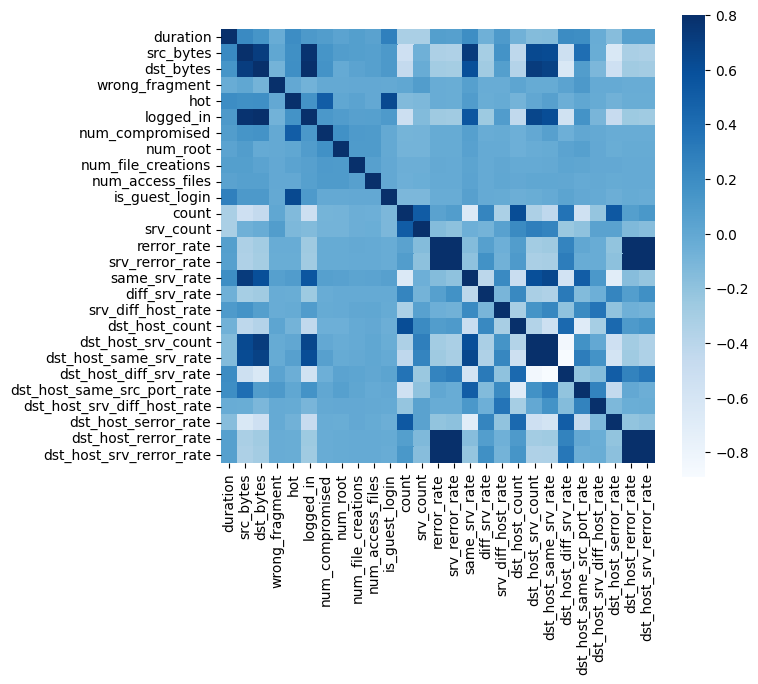

In [119]:
# Check heat map with blue colormap
corr_mat = X.corr(method='spearman')
f, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(corr_mat, vmax=.8, square=True, cmap='Blues', ax=ax)
plt.show()

# **Feature Engineering**

## 1. For Binary Classification

In [120]:
bin_df = df.copy()
bin_df = bin_df.drop(['attack','type_of_attack'],axis=1)
bin_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,-0.109923,tcp,private,SH,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,...,-0.082423,-1.038634,-1.132106,4.916170,2.683669,-0.156926,1.459975,-0.325076,-0.33803,anomaly
1,-0.109923,tcp,private,S0,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,...,0.724452,-1.002495,-1.109803,0.012374,-0.469117,-0.156926,1.571182,-0.325076,-0.33803,anomaly
2,-0.109923,tcp,http,SF,-0.006687,-0.004194,-0.08804,-0.08037,1.238582,-0.010951,...,-0.705454,1.012281,1.075846,-0.443793,-0.435930,-0.156926,-0.652955,-0.325076,-0.33803,normal
3,-0.109923,tcp,http,SF,-0.006697,-0.004896,-0.08804,-0.08037,1.238582,-0.010951,...,-1.818739,1.256222,1.075846,-0.443793,0.095066,-0.156926,-0.652955,-0.325076,-0.33803,normal
4,-0.109544,tcp,smtp,SF,-0.006531,-0.004955,-0.08804,-0.08037,1.238582,-0.010951,...,0.183131,0.343701,0.139139,-0.329751,-0.469117,-0.156926,-0.652955,-0.325076,-0.33803,normal


### 1.1. Encoding

#### Categorical Features to One Hot Encoding

In [121]:
# explore categorical features
print('Training Data:')
for col_name in bin_df.columns:
    if col_name not in ['target', 'attack', 'type_of_attack'] and bin_df[col_name].dtype == 'object':
        unique_cat = len(bin_df[col_name].unique())
        print(f"Feature '{col_name}' has {unique_cat} categories")

Training Data:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories


In [122]:
# selecting categorical data attributes
cat_col = ['protocol_type','service','flag']

# creating a dataframe with only categorical attributes
cat_df = bin_df[cat_col]
cat_df.head()

,protocol_type,service,flag
0,tcp,private,SH
1,tcp,private,S0
2,tcp,http,SF
3,tcp,http,SF
4,tcp,smtp,SF


In [123]:
# one-hot-encoding categorical attributes using pandas.get_dummies() function
cat_df = pd.get_dummies(cat_df, columns=cat_col, dtype=int)
cat_df.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Join encoded categorical dataframe with the non-categorical dataframe.

In [124]:
# Simpan kolom 'target' dalam variabel terpisah
target_col = bin_df['target']

# Hapus kolom 'target' dan categorical column sebelum di-encoding dari DataFrame
bin_df.drop('target', axis=1, inplace=True)
bin_df.drop('flag', axis=1, inplace=True)
bin_df.drop('protocol_type', axis=1, inplace=True)
bin_df.drop('service', axis=1, inplace=True)

# Gabungkan DataFrame cat_df ke dalam bin_df
bin_df = bin_df.join(cat_df)

# Sisipkan kolom 'target' kembali ke paling kanan DataFrame
bin_df['target'] = target_col

bin_df.shape

(108616, 112)

In [125]:
bin_df

,duration,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,num_root,num_file_creations,num_access_files,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,target
0,-0.109923,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,0,0,0,0,0,1,anomaly
1,-0.109923,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,1,0,0,0,0,0,anomaly
2,-0.109923,-0.006687,-0.004194,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,0,0,0,0,1,0,normal
3,-0.109923,-0.006697,-0.004896,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,0,0,0,0,1,0,normal
4,-0.109544,-0.006531,-0.004955,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,0,0,0,0,1,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112440,-0.108028,-0.006473,-0.004955,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,0,0,0,0,1,0,normal
112442,-0.109923,-0.006682,-0.004855,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,0,0,0,0,1,0,normal
112443,-0.109923,-0.006672,-0.004864,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,0,0,0,0,1,0,normal
112444,-0.109923,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,-0.011706,-0.02543,-0.040703,...,1,0,0,0,0,0,0,0,0,anomaly


#### Label to Label Encoding

In [126]:
# creating a dataframe with binary labels (normal, anomaly)
bin_df['target_label'] = bin_df['target'].replace({'normal': 0, 'anomaly': 1})

In [127]:
bin_df

,duration,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,num_root,num_file_creations,num_access_files,...,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,target,target_label
0,-0.109923,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,0,0,0,0,1,anomaly,1
1,-0.109923,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,1,0,0,0,0,0,anomaly,1
2,-0.109923,-0.006687,-0.004194,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,0,0,0,1,0,normal,0
3,-0.109923,-0.006697,-0.004896,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,0,0,0,1,0,normal,0
4,-0.109544,-0.006531,-0.004955,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,0,0,0,1,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112440,-0.108028,-0.006473,-0.004955,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,0,0,0,1,0,normal,0
112442,-0.109923,-0.006682,-0.004855,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,0,0,0,1,0,normal,0
112443,-0.109923,-0.006672,-0.004864,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,0,0,0,1,0,normal,0
112444,-0.109923,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,-0.011706,-0.02543,-0.040703,...,0,0,0,0,0,0,0,0,anomaly,1


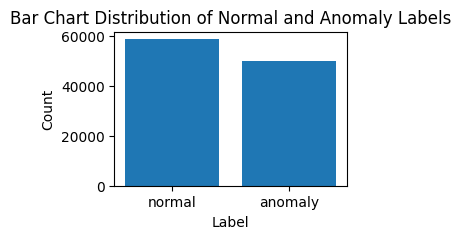

In [128]:
# Menghitung jumlah 'normal' dan 'abnormal' dalam kolom 'label'
label_counts = bin_df['target'].value_counts()

# Membuat bar chart
plt.figure(figsize=(3, 2))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Bar Chart Distribution of Normal and Anomaly Labels')
plt.show()

In [129]:
# # label encoder
# def label_encoder(df):
#     columns_to_encode = ['target', 'attack', 'type_of_attack']
#     for col in columns_to_encode:
#         if col in df.columns:
#             label_encoder = LabelEncoder()
#             df[f"{col}_ohe"] 
#             df[f"{col}_ohe"] = label_encoder.fit_transform(df[col])

In [130]:
# # Membuat kolom 'target' dengan nilai awal 'anomaly'
# df['target'] = 'anomaly'

# # Mengganti nilai kolom 'target' berdasarkan nilai kolom 'type_of_attack'
# df.loc[df['type_of_attack'] == 'normal', 'target'] = 'normal'

# # Sisipkan kolom 'target' tepat sebelum kolom terakhir
# df.insert(df.columns.get_loc('type_of_attack'), 'target', df.pop('target'))

In [131]:
# label_encoder(bin_df1)

### 1.2. Feature Scaling

In [132]:
# feature
X_bin = bin_df.drop(columns=['target','target_label'])
# label
y_bin = bin_df[['target','target_label']]

In [133]:
X_bin.shape, y_bin.shape

((108616, 111), (108616, 2))

In [134]:
from sklearn.preprocessing import StandardScaler

# Inisialisasi objek StandardScaler
scaler = StandardScaler()

# Fit dan transformasi scaler pada DataFrame X_bin
X_bin_scaled = scaler.fit_transform(X_bin)

# Menghasilkan DataFrame baru dengan data yang telah diubah skala
X_bin = pd.DataFrame(X_bin_scaled, columns=X_bin.columns)

# Tampilkan DataFrame yang telah diubah skala
X_bin

,duration,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,num_root,num_file_creations,num_access_files,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.109923,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,-0.011706,-0.02543,-0.040703,...,-0.297215,-0.111806,-0.028475,-0.139694,-0.633367,-0.053413,-0.032271,-0.018952,-1.208739,22.506697
1,-0.109923,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,-0.011706,-0.02543,-0.040703,...,-0.297215,-0.111806,-0.028475,-0.139694,1.578864,-0.053413,-0.032271,-0.018952,-1.208739,-0.044431
2,-0.109923,-0.006687,-0.004194,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,-0.297215,-0.111806,-0.028475,-0.139694,-0.633367,-0.053413,-0.032271,-0.018952,0.827308,-0.044431
3,-0.109923,-0.006697,-0.004896,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,-0.297215,-0.111806,-0.028475,-0.139694,-0.633367,-0.053413,-0.032271,-0.018952,0.827308,-0.044431
4,-0.109544,-0.006531,-0.004955,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,-0.297215,-0.111806,-0.028475,-0.139694,-0.633367,-0.053413,-0.032271,-0.018952,0.827308,-0.044431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108611,-0.108028,-0.006473,-0.004955,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,-0.297215,-0.111806,-0.028475,-0.139694,-0.633367,-0.053413,-0.032271,-0.018952,0.827308,-0.044431
108612,-0.109923,-0.006682,-0.004855,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,-0.297215,-0.111806,-0.028475,-0.139694,-0.633367,-0.053413,-0.032271,-0.018952,0.827308,-0.044431
108613,-0.109923,-0.006672,-0.004864,-0.08804,-0.08037,1.238582,-0.010951,-0.011706,-0.02543,-0.040703,...,-0.297215,-0.111806,-0.028475,-0.139694,-0.633367,-0.053413,-0.032271,-0.018952,0.827308,-0.044431
108614,-0.109923,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,-0.011706,-0.02543,-0.040703,...,-0.297215,8.944063,-0.028475,-0.139694,-0.633367,-0.053413,-0.032271,-0.018952,-1.208739,-0.044431


### 1.3. Save Binary Data

In [135]:
# Menggabungkan X_bin_scaled_df dengan y_bin
binary_df = pd.concat([X_bin, y_bin], axis=1)

# Simpan sebagai file CSV
binary_df.to_csv('D:\DAC-2023\Dataset\\binary.csv', index=False)

#### **SMOTEENN Method**

In [136]:
# # Define the list of target columns in order
# target_columns = ['target','attack','type_of_attack'] # Replace with your actual target column names

# # Create an empty DataFrame to store the resampled data
# resampled_df = pd.DataFrame()

# # Loop through each target column
# for target_col in target_columns:
#     # Separate features and target for the current target
#     X_target = X  # Features
#     y_target = y[target_col] # Target
    
#     # Apply SMOTE-ENN to balance the current target
#     smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
#     X_resampled, y_resampled = smote_enn.fit_resample(X_target, y_target)
    
#     # Combine the resampled data with the resampled_df
#     resampled_data = pd.DataFrame(data=X_resampled, columns=X_target.columns)
#     resampled_data[target_col] = y_resampled
#     resampled_df = pd.concat([resampled_df, resampled_data], axis=0)

# # At this point, 'resampled_df' should contain balanced data for all target columns

# # Path to save the resampled data
# file_path = 'resampled_data.csv'

# # Save the resampled DataFrame to a CSV file
# resampled_df.to_csv(file_path, index=False)

In [137]:
# # Load resampled data
# df = pd.read_csv('D:\DAC-2023\\resampled_data.csv')

In [138]:
# df

In [139]:
# class_distribution = df['target'].value_counts().reset_index()
# class_distribution.columns = ['target', 'count']

# fig = px.treemap(class_distribution, 
#                  path=['target'], 
#                  values='count', 
#                  title='Distribution of Target')
# fig.show()

## 2. For Multiclass Classification

In [140]:
attack_df = df.copy()
attack_df = attack_df.drop(['target','type_of_attack'],axis=1)
attack_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,-0.109923,tcp,private,SH,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,...,-0.082423,-1.038634,-1.132106,4.916170,2.683669,-0.156926,1.459975,-0.325076,-0.33803,probe
1,-0.109923,tcp,private,S0,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,...,0.724452,-1.002495,-1.109803,0.012374,-0.469117,-0.156926,1.571182,-0.325076,-0.33803,dos
2,-0.109923,tcp,http,SF,-0.006687,-0.004194,-0.08804,-0.08037,1.238582,-0.010951,...,-0.705454,1.012281,1.075846,-0.443793,-0.435930,-0.156926,-0.652955,-0.325076,-0.33803,normal
3,-0.109923,tcp,http,SF,-0.006697,-0.004896,-0.08804,-0.08037,1.238582,-0.010951,...,-1.818739,1.256222,1.075846,-0.443793,0.095066,-0.156926,-0.652955,-0.325076,-0.33803,normal
4,-0.109544,tcp,smtp,SF,-0.006531,-0.004955,-0.08804,-0.08037,1.238582,-0.010951,...,0.183131,0.343701,0.139139,-0.329751,-0.469117,-0.156926,-0.652955,-0.325076,-0.33803,normal


In [141]:
toa_df = df.copy()
toa_df = toa_df.drop(['target','attack'],axis=1)
toa_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack
0,-0.109923,tcp,private,SH,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,...,-0.082423,-1.038634,-1.132106,4.916170,2.683669,-0.156926,1.459975,-0.325076,-0.33803,nmap
1,-0.109923,tcp,private,S0,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,...,0.724452,-1.002495,-1.109803,0.012374,-0.469117,-0.156926,1.571182,-0.325076,-0.33803,neptune
2,-0.109923,tcp,http,SF,-0.006687,-0.004194,-0.08804,-0.08037,1.238582,-0.010951,...,-0.705454,1.012281,1.075846,-0.443793,-0.435930,-0.156926,-0.652955,-0.325076,-0.33803,normal
3,-0.109923,tcp,http,SF,-0.006697,-0.004896,-0.08804,-0.08037,1.238582,-0.010951,...,-1.818739,1.256222,1.075846,-0.443793,0.095066,-0.156926,-0.652955,-0.325076,-0.33803,normal
4,-0.109544,tcp,smtp,SF,-0.006531,-0.004955,-0.08804,-0.08037,1.238582,-0.010951,...,0.183131,0.343701,0.139139,-0.329751,-0.469117,-0.156926,-0.652955,-0.325076,-0.33803,normal


### 2.1. Encoding

#### Encoding for attack_df

In [142]:
# creating a dataframe with labels (normal, dos, probe)
attack_df['attack_label'] = attack_df['attack'].replace({'normal': 0, 'dos':1, 'probe':2})

In [143]:
attack_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,attack_label
0,-0.109923,tcp,private,SH,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,...,-1.038634,-1.132106,4.916170,2.683669,-0.156926,1.459975,-0.325076,-0.338030,probe,2
1,-0.109923,tcp,private,S0,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,...,-1.002495,-1.109803,0.012374,-0.469117,-0.156926,1.571182,-0.325076,-0.338030,dos,1
2,-0.109923,tcp,http,SF,-0.006687,-0.004194,-0.08804,-0.08037,1.238582,-0.010951,...,1.012281,1.075846,-0.443793,-0.435930,-0.156926,-0.652955,-0.325076,-0.338030,normal,0
3,-0.109923,tcp,http,SF,-0.006697,-0.004896,-0.08804,-0.08037,1.238582,-0.010951,...,1.256222,1.075846,-0.443793,0.095066,-0.156926,-0.652955,-0.325076,-0.338030,normal,0
4,-0.109544,tcp,smtp,SF,-0.006531,-0.004955,-0.08804,-0.08037,1.238582,-0.010951,...,0.343701,0.139139,-0.329751,-0.469117,-0.156926,-0.652955,-0.325076,-0.338030,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112440,-0.108028,tcp,smtp,SF,-0.006473,-0.004955,-0.08804,-0.08037,1.238582,-0.010951,...,0.009410,0.317560,-0.272730,-0.435930,-0.156926,-0.652955,-0.325076,-0.338030,normal,0
112442,-0.109923,tcp,http,SF,-0.006682,-0.004855,-0.08804,-0.08037,1.238582,-0.010951,...,1.256222,1.075846,-0.443793,-0.402743,-0.156926,-0.608472,-0.325076,-0.338030,normal,0
112443,-0.109923,tcp,http,SF,-0.006672,-0.004864,-0.08804,-0.08037,1.238582,-0.010951,...,1.256222,1.075846,-0.443793,-0.469117,-0.156926,-0.652955,-0.325076,-0.338030,normal,0
112444,-0.109923,tcp,discard,RSTO,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,...,-0.984425,-1.087501,-0.101668,-0.469117,-0.156926,-0.652955,3.106410,2.971509,dos,1


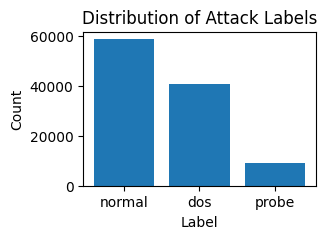

In [144]:
# Menghitung jumlah 'normal' dan 'abnormal' dalam kolom 'label'
label_counts = attack_df['attack'].value_counts()

# Membuat bar chart
plt.figure(figsize=(3, 2))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Attack Labels')
plt.show()

#### Encoding for type_of_attack

In [145]:
toa_df.type_of_attack.unique()

array(['nmap', 'neptune', 'normal', 'Denial of Service Attack',
       'portsweep', 'satan', 'ipsweep', 'smurf'], dtype=object)

In [146]:
# creating a dataframe with labels (normal, dos, probe)
toa_df['toa_label'] = toa_df['type_of_attack'].replace({'normal': 0, 'Denial of Service Attack':1, 
                                                        'neptune':2, 'smurf':3, 'nmap':4,
                                                        'portsweep':5, 'satan':6, 'ipsweep':7})

In [147]:
toa_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack,toa_label
0,-0.109923,tcp,private,SH,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,...,-1.038634,-1.132106,4.916170,2.683669,-0.156926,1.459975,-0.325076,-0.338030,nmap,4
1,-0.109923,tcp,private,S0,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,...,-1.002495,-1.109803,0.012374,-0.469117,-0.156926,1.571182,-0.325076,-0.338030,neptune,2
2,-0.109923,tcp,http,SF,-0.006687,-0.004194,-0.08804,-0.08037,1.238582,-0.010951,...,1.012281,1.075846,-0.443793,-0.435930,-0.156926,-0.652955,-0.325076,-0.338030,normal,0
3,-0.109923,tcp,http,SF,-0.006697,-0.004896,-0.08804,-0.08037,1.238582,-0.010951,...,1.256222,1.075846,-0.443793,0.095066,-0.156926,-0.652955,-0.325076,-0.338030,normal,0
4,-0.109544,tcp,smtp,SF,-0.006531,-0.004955,-0.08804,-0.08037,1.238582,-0.010951,...,0.343701,0.139139,-0.329751,-0.469117,-0.156926,-0.652955,-0.325076,-0.338030,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112440,-0.108028,tcp,smtp,SF,-0.006473,-0.004955,-0.08804,-0.08037,1.238582,-0.010951,...,0.009410,0.317560,-0.272730,-0.435930,-0.156926,-0.652955,-0.325076,-0.338030,normal,0
112442,-0.109923,tcp,http,SF,-0.006682,-0.004855,-0.08804,-0.08037,1.238582,-0.010951,...,1.256222,1.075846,-0.443793,-0.402743,-0.156926,-0.608472,-0.325076,-0.338030,normal,0
112443,-0.109923,tcp,http,SF,-0.006672,-0.004864,-0.08804,-0.08037,1.238582,-0.010951,...,1.256222,1.075846,-0.443793,-0.469117,-0.156926,-0.652955,-0.325076,-0.338030,normal,0
112444,-0.109923,tcp,discard,RSTO,-0.006743,-0.005030,-0.08804,-0.08037,-0.807375,-0.010951,...,-0.984425,-1.087501,-0.101668,-0.469117,-0.156926,-0.652955,3.106410,2.971509,neptune,2


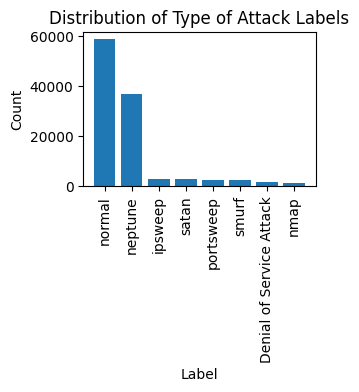

In [148]:
# Menghitung jumlah 'normal' dan 'abnormal' dalam kolom 'label'
label_counts = toa_df['type_of_attack'].value_counts()

# Membuat bar chart
plt.figure(figsize=(3, 2))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Type of Attack Labels')
plt.xticks(rotation=90)
plt.show()

### 2.2. Save Multiclass Data

#### attack.csv

In [149]:
# Feature
X_bin
# Target
y_attack = attack_df[['attack','attack_label']]

In [150]:
# Menggabungkan X_bin dengan y_attack
attack_df = pd.concat([X_bin, y_attack], axis=1)

# Simpan sebagai file CSV
attack_df.to_csv('D:\DAC-2023\Dataset\\attack.csv', index=False)

#### toa.csv

In [151]:
# Feature
X_bin
# Target
y_toa = toa_df[['type_of_attack','toa_label']]

In [152]:
# Menggabungkan X_bin dengan y_toa
toa_df = pd.concat([X_bin, y_attack], axis=1)

# Simpan sebagai file CSV
toa_df.to_csv('D:\DAC-2023\Dataset\\toa.csv', index=False)

# **Feature Selection**

### 1. Train and Test Sets

In [ ]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y['target'],
    test_size=0.2,
    random_state=5)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

### 2. RFE - Random Forest

In [ ]:
# Initialize the RandomForestClassifier
rfc = RandomForestClassifier()

# Initialize the RFE with the RandomForestClassifier
rfe = RFE(rfc, n_features_to_select=10)

# Fit the RFE to the training data
rfe = rfe.fit(X_train, y_train)

# Get the support from RFE, indicating which features are selected
support = rfe.support_

# Get the ranking from RFE, indicating the importance ranking of features
ranking = rfe.ranking_

# Initialize a list to store selected features
selected_features = []

# Initialize a list to store AUC scores at each iteration
auc_scores = []

# Loop through the selected features and compute AUC at each iteration
for i, (is_selected, feature) in enumerate(zip(support, X_train.columns)):
    if is_selected:
        selected_features.append(feature)
        # Train a model with the selected features
        rfc.fit(X_train[selected_features], y_train)
        # Make predictions on the test set
        y_pred = rfc.predict_proba(X_test[selected_features])[:, 1]
        # Calculate the AUC score
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)
        print(f"Iteration {i + 1}: AUC = {auc:.4f}")

# Now 'selected_features' contains the final selected features
# 'auc_scores' contains the AUC scores at each iteration


In [ ]:
selected_features

### 3. RFA - Random Forest

In [ ]:
# Initialize the RandomForestClassifier
rfc = RandomForestClassifier()

# Initialize empty lists to store selected features and AUC scores
selected_features = []
auc_scores = []

# Initialize a list of all features
all_features = X_train.columns.tolist()

# Initialize a variable to store the best AUC score
best_auc = 0

# Loop through the features and add them one by one based on AUC improvement
while len(all_features) > 0:
    best_feature = None
    for feature in all_features:
        # Try adding the feature to the selected features
        current_features = selected_features + [feature]
        # Train a model with the current selected features
        rfc.fit(X_train[current_features], y_train)
        # Make predictions on the test set
        y_pred = rfc.predict_proba(X_test[current_features])[:, 1]
        # Calculate the AUC score
        auc = roc_auc_score(y_test, y_pred)
        # Check if the AUC improved
        if auc > best_auc:
            best_auc = auc
            best_feature = feature
    if best_feature is not None:
        selected_features.append(best_feature)
        auc_scores.append(best_auc)
        all_features.remove(best_feature)
        print(f"Selected Feature: {best_feature}, AUC = {best_auc:.4f}")
    else:
        break

# Now 'selected_features' contains the final selected features
# 'auc_scores' contains the AUC scores at each iteration

In [ ]:
selected_features

### 4. RFE - Gradient Boosting

In [ ]:
# the ML model for which we want to select features
model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=10
)

# Setup the RFE selector

sel = RecursiveFeatureElimination(
    variables=None, # automatically evaluate all numerical variables
    estimator = model, # the ML model
    scoring = 'roc_auc', # the metric we want to evalute
    threshold = 0.0005, # the maximum performance drop allowed to remove a feature
    cv=2, # cross-validation
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
sel.fit(X_train, y_train)

In [ ]:
# performance of model trained using all features
sel.initial_model_performance_

In [ ]:
all_columns = X_train.columns.tolist()

# List of columns to be dropped
columns_to_drop = sel.features_to_drop_

# Find columns that are not in the list of columns to drop
columns_to_keep = [col for col in all_columns if col not in columns_to_drop]

# Now, 'columns_to_keep' contains the columns that are not in the list of columns to drop
print("Columns to keep:")
print(columns_to_keep)

### 4. RFA - Gradient Boosting

In [ ]:
# Setup the RFA selector
rfa = RecursiveFeatureAddition(
    variables=None,  # automatically evaluate all numerical variables
    estimator=model,  # the ML model
    scoring='roc_auc',  # the metric we want to evalute
    threshold=0.0001,  # the minimum performance increase needed to select a feature
    cv=2,  # cross-validation
)

rfa.fit(X_train, y_train)

In [ ]:
# performance of model trained using all features

rfa.initial_model_performance_

In [ ]:
all_columns = X_train.columns.tolist()

# List of columns to be dropped
columns_to_drop = sel.features_to_drop_

# Find columns that are not in the list of columns to drop
columns_to_keep = [col for col in all_columns if col not in columns_to_drop]

# Now, 'columns_to_keep' contains the columns that are not in the list of columns to drop
print("Columns to keep:")
print(columns_to_keep)